In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gp
from geopandas import GeoDataFrame
from shapely.geometry import LineString
from shapely.geometry import MultiPoint
from shapely.geometry import Point
import shapely
import networkx as nx
import os.path
from os import path
import pathlib
import pandas as pd
from datetime import datetime
import numpy as np

import geopy.distance


from OSMPythonTools.api import Api as osm_api
ox.config(log_console=True, use_cache=True)

In [2]:
# Isochrone Maxspeed

start_point = (52.5153, 13.4040)
hours_of_day = range(24)
speed_aggregate = 'mean' # min, mean, max
local_set = True
path = 'travel_time+uberJan2020.graphml'

In [3]:
#G = ox.graph.graph_from_point(start_point, dist=dist, dist_type='network', network_type='drive')
#, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)


In [5]:
if local_set:
    G = ox.graph.graph_from_place('Berlin, Germany', retain_all=True, buffer_dist=2500, network_type='drive', simplify=False)
    speed_df_orig = pd.read_csv('../data/movement-speeds-hourly-berlin-2020-1.csv')
else:
    G = ox.io.load_graphml(path)#, node_type=None, node_dtypes=None, edge_dtypes=None)
    

In [6]:
# Load Uber speeds into osm Graph

if speed_aggregate == 'min':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).min()['speed_kph_mean'].reset_index()
elif speed_aggregate == 'mean':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).mean()['speed_kph_mean'].reset_index()
elif speed_aggregate == 'max':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).max()['speed_kph_mean'].reset_index()

    
for way in speed_df.iloc():
    node_ids = [int(way['osm_start_node_id']),int(way['osm_end_node_id'])]
    try:
        G.edges[min(node_ids),max(node_ids),0]['real_speed'] = way['speed_kph_mean']
    except:
        pass


In [7]:
# Calculate Way Times for each Segment

for u, v, k, data in G.edges(data=True, keys=True):
    #print('maxspeed' in data.keys())
    if ('maxspeed' in data.keys()):
        #print(isinstance(data['maxspeed'], list))
        #print(data['maxspeed'])
        #print(type(data['maxspeed']))
        if(isinstance(data['maxspeed'], list)):
            
            
            #print(type(data['maxspeed']))
            #print(data['maxspeed'])
            speed = min(data['maxspeed'])
            #print(speed)
        else:
            speed = data['maxspeed']
    else:
        speed = 50.0
        
    if (speed == 'DE:urban'):
        speed = 50.0
    elif (speed == 'walk'):
        speed = 6.0
    elif (speed == 'none'):
        speed = 130.0
        
    #print(speed)    
    data['time'] = data['length'] / (float(speed) * 1000 / 60)
    data['maxspeed'] = float(speed)
    #print(data['test_maxspeed'])

    
    
    if ('real_speed' in data.keys()):
        real_speed = float(data['real_speed'])
    else:
        real_speed = speed
    data['real_time'] = data['length'] / (float(real_speed)* 1000 / 60)

ox.save_graphml(G, filepath='./travel_time+uberJan2020.graphml')

In [8]:
#nodes, edges = ox.graph_to_gdfs(G)
#set(list(edges['maxspeed'].values))

In [9]:
#center_node = ox.get_nearest_node(G, start_point)

#subgraph_15 = nx.ego_graph(G, center_node, radius=5, distance='time')
#subgraph_15_real = nx.ego_graph(G, center_node, radius=5, distance='real_time')

#ox.plot_graph(subgraph_15)
#ox.plot_graph(subgraph_15_real)



In [10]:
#nodes, edges = ox.graph_to_gdfs(subgraph_15_real)

#lat, long = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy

#nodes['geometry'].plot()
#zip(lat,long)[0]

#MultiPoint(nodes.reset_index()['geometry']).convex_hull
    
#dist = [geopy.distance.geodesic(point,start_point).meters for point in zip(long,lat)]
#np.mean(dist)

In [11]:
#nodes, edges = ox.graph_to_gdfs()
#edges = edges.sort_values('time')
#nodes

In [12]:
def getAvgIsochroneDistStreet(start_point, travel_time_min, real_speed=True, plot_subgraph=False):
    x, y = Point(start_point).xy
    center_node = ox.get_nearest_node(G, (y[0],x[0]))
    dist=[]
    distance_type = 'real_time' if real_speed else 'time'
    
    subgraph = nx.ego_graph(G, center_node, radius=travel_time_min, distance=distance_type)
    
    dist = []
    if plot_subgraph:
        ox.plot_graph(subgraph)
    nodes, edges = ox.graph_to_gdfs(subgraph)
    lat, long = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy
    #dist = []
    
    for point in zip(lat,long):
        try:
            dist.append(geopy.distance.geodesic(point,start_point).meters)
        except:
            dist.append(float(0.0))
    
    return np.mean(dist)
                            

In [12]:
#getAvgIsochroneDistStreet((52.617670, 13.223318), 5)
getAvgIsochroneDistStreet((13.223318, 52.617670), 5)

2910.7369366390253

In [13]:
#getAvgIsochroneDistStreet((52.617670, 13.223318), 5)
getAvgIsochroneDistStreet((13.223318, 52.617670), 5)

2910.7369366390253

In [14]:
def getAvgIsochroneDistStreet_list(list_of_points, travel_time_min):
    list_of_avg = []
    for point in list_of_points:
        try:
            list_of_avg.append(getAvgIsochroneDistStreet(point, travel_time_min, real_speed=True, plot_subgraph=False))
        except:
            list_of_avg.append(float(0.0))
    return list_of_avg
    #return [getAvgIsochroneDistStreet(point, travel_time_min, real_speed=True, plot_subgraph=False) for point in list_of_points ]

In [15]:
list_of_points = [(13.3355015, 52.5652055),
 (13.3466053, 52.567033),
 (13.3522545, 52.567738),
 (13.339564, 52.5640768),
 (13.3429006, 52.5633975),
 (13.3373679, 52.5587807),
 (13.3306441, 52.5626152),
 (13.3277078, 52.5640457),
 (13.3202135, 52.5659103),
 (13.3460089, 52.5746796),
 (13.3521078, 52.573666),
 (13.223318, 52.617670)]

In [164]:
list_of_points

[(13.3355015, 52.5652055),
 (13.3466053, 52.567033),
 (13.3522545, 52.567738),
 (13.339564, 52.5640768),
 (13.3429006, 52.5633975),
 (13.3373679, 52.5587807),
 (13.3306441, 52.5626152),
 (13.3277078, 52.5640457),
 (13.3202135, 52.5659103),
 (13.3460089, 52.5746796),
 (13.3521078, 52.573666),
 (13.223318, 52.61767)]

In [16]:
list_of_points

[(13.3355015, 52.5652055),
 (13.3466053, 52.567033),
 (13.3522545, 52.567738),
 (13.339564, 52.5640768),
 (13.3429006, 52.5633975),
 (13.3373679, 52.5587807),
 (13.3306441, 52.5626152),
 (13.3277078, 52.5640457),
 (13.3202135, 52.5659103),
 (13.3460089, 52.5746796),
 (13.3521078, 52.573666),
 (13.223318, 52.61767)]

In [17]:
type(list_of_points)

list

In [18]:
type(list_of_points[0])

tuple

In [167]:
getAvgIsochroneDistStreet_list(list_of_points, 1)

[966.3989078822983,
 893.7996979168427,
 775.1927108393782,
 549.3071439668252,
 802.4380705938473,
 779.0320054908456,
 923.2139286447663,
 846.7789439417503,
 836.629831889678,
 871.7162721339846,
 960.6990439838968,
 248.1645827665362]

In [19]:
getAvgIsochroneDistStreet_list(list_of_points, 1)

[966.3989078822983,
 893.7996979168427,
 775.1927108393782,
 549.3071439668252,
 802.4380705938473,
 779.0320054908456,
 923.2139286447663,
 846.7789439417503,
 836.629831889678,
 871.7162721339846,
 960.6990439838968,
 248.1645827665362]

#  AvgIsoDistance of a PointList

<AxesSubplot:>

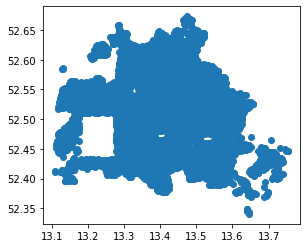

In [21]:
#samplepoints = gp.read_file("../results/sample-points.json")
samplepoints = gp.read_file("../results/sample-points.geojson")
samplepoints.plot()

In [22]:
samplepoints

,geometry
0,POINT (13.40766 52.39305)
1,POINT (13.29389 52.62069)
2,POINT (13.55983 52.39874)
3,POINT (13.32518 52.48467)
4,POINT (13.46647 52.66642)
...,...
9995,POINT (13.26623 52.51403)
9996,POINT (13.33180 52.46694)
9997,POINT (13.59042 52.51521)
9998,POINT (13.39571 52.44361)


In [23]:
geodf = gp.read_file("../results/isochrones-drive-15.geojson")


In [24]:
#samplepoints.geometry.tolist()

In [25]:
samplepoints = gp.read_file("../results/sample-points.csv")

C:\Users\micha\anaconda3\envs\geo\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [26]:
samplepoints = samplepoints[['field_1', 'field_2']]
samplepoints

,field_1,field_2
0,13.407658767026547,52.393048113138015
1,13.293887436892298,52.62069091743619
2,13.559826799428494,52.39873609001193
3,13.325182388650976,52.484672415195845
4,13.466470594920276,52.6664231476963
...,...,...
9995,13.266233615413078,52.5140268518015
9996,13.331797338216681,52.466937990238605
9997,13.590419553202727,52.51520653463045
9998,13.395710236497312,52.44360655522949


In [27]:
samplepoints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   field_1  10000 non-null  object
 1   field_2  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [28]:
# changing the dataframe  
# data types to string 
samplepoints = samplepoints.astype(float) 
  
# show the data types  
# of dataframe 
samplepoints.dtypes

field_1    float64
field_2    float64
dtype: object

In [29]:
samplepoints = samplepoints.apply(tuple, axis=1)


In [30]:
samplepoints = samplepoints.tolist()

In [31]:
samplepoints[0:5]

[(13.407658767026547, 52.393048113138015),
 (13.293887436892298, 52.62069091743619),
 (13.559826799428494, 52.39873609001193),
 (13.325182388650976, 52.484672415195845),
 (13.466470594920276, 52.6664231476963)]

In [32]:
#geodf = geodf.apply(tuple, axis=1)

In [33]:
#df = pd.read_json("../results/sample-points.geojson")
#print("len ("+str(len(df))+")")
#df.head(5)

In [34]:
#geodf = gp.GeoDataFrame(samplepoints)
#print("len ("+str(len(geodf))+")")
#geodf.head(5)

In [35]:
#geodf = gp.GeoDataFrame(geodf)
#geodf.rename(columns = {0:'geometry'}, inplace = True) 
#geodf

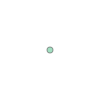

In [36]:
geodf.geometry[1]

In [37]:
#print(f'NumPy Array:\n{arr}')
#list1 = geodf.values().toList()
#list1=[]
#for i in range(len(geodf)):
#    list1.append(geodf.geometry[i])


In [38]:
list1 = samplepoints

# Fixed

# 5 Minute Calculation

In [39]:
avg_iso_list = getAvgIsochroneDistStreet_list(list1,5)
#avg_iso_list = getAvgIsochroneDistStreet_list(list1[182:199], 5)

In [40]:
avg_iso_list[0:10]

[4511.410114105008,
 3441.480203037102,
 3616.025751478763,
 4536.1740164189805,
 3548.545198114402,
 3345.7143986817114,
 4442.512393771328,
 4016.725200777777,
 5387.435185750388,
 3831.962818340905]

In [41]:
geo_points = gp.read_file("../results/sample-points.geojson")

In [42]:
geo_points

,geometry
0,POINT (13.40766 52.39305)
1,POINT (13.29389 52.62069)
2,POINT (13.55983 52.39874)
3,POINT (13.32518 52.48467)
4,POINT (13.46647 52.66642)
...,...
9995,POINT (13.26623 52.51403)
9996,POINT (13.33180 52.46694)
9997,POINT (13.59042 52.51521)
9998,POINT (13.39571 52.44361)


[(13.407658767026547, 52.393048113138015),
 (13.293887436892298, 52.62069091743619),
 (13.559826799428494, 52.39873609001193),
 (13.325182388650976, 52.484672415195845),
 (13.466470594920276, 52.6664231476963)]

In [43]:
geo_points["avg_dist"] = avg_iso_list

In [44]:
geo_points

,geometry,avg_dist
0,POINT (13.40766 52.39305),4511.410114
1,POINT (13.29389 52.62069),3441.480203
2,POINT (13.55983 52.39874),3616.025751
3,POINT (13.32518 52.48467),4536.174016
4,POINT (13.46647 52.66642),3548.545198
...,...,...
9995,POINT (13.26623 52.51403),5338.312755
9996,POINT (13.33180 52.46694),4770.537873
9997,POINT (13.59042 52.51521),4322.059142
9998,POINT (13.39571 52.44361),4141.479509


In [ ]:
#geodf["geometry"] = Point()
#for i in range(len(geodf)):
#    geodf.geometry[i] = Point(geodf.lon[i],geodf.lat[i],)
#del geodf["lon"]
#del geodf["lat"]
#geodf = geodf[['geometry','avg_dist']]
#geodf

In [46]:
geo_points.to_file("../results/isochrones-drive-5.geojson", driver='GeoJSON')

# 10 Minute Calculation

In [47]:
avg_iso_list = getAvgIsochroneDistStreet_list(list1, 10)
geo_points["avg_dist"] = avg_iso_list
geo_points.to_file("../results/isochrones-drive-10.geojson", driver='GeoJSON')

# 15 Minute Calculation

In [ ]:
avg_iso_list = getAvgIsochroneDistStreet_list(list1, 15)
geo_points["avg_dist"] = avg_iso_list
geo_points.to_file("../results/isochrones-drive-15.geojson", driver='GeoJSON')

# 20 Minutes Calculation

In [ ]:
avg_iso_list = getAvgIsochroneDistStreet_list(list1, 20)
geo_points["avg_dist"] = avg_iso_list
geo_points.to_file("../results/isochrones-drive-20.geojson", driver='GeoJSON')

In [161]:
avg_iso_list[0:100]

[31359.76148149969, 30267.012743275332]